# 2. Decentralized Optimizaiton

## 2.1 Network topologies

To run decentralized algorithms, we have to set up the network topology. 

In [1]:
import networkx as nx   # nx will be used for network topology creating and plotting
from bluefog.common import topology_util
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1.1 Ring topology

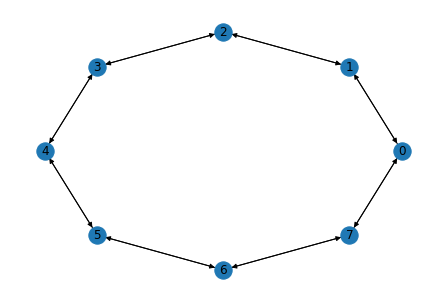

In [2]:
G = topology_util.RingGraph(8)
labels={i: i for i in range(8)}
nx.draw_circular(G, labels=labels)

### 2.1.2 Star topology

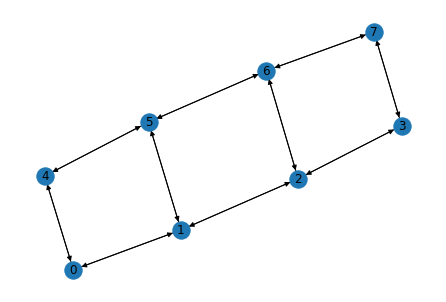

In [3]:
G = topology_util.MeshGrid2DGraph(8)
labels={i: i for i in range(8)}
nx.draw_spring(G, labels=labels)

### 2.1.3 Exponential-two topology

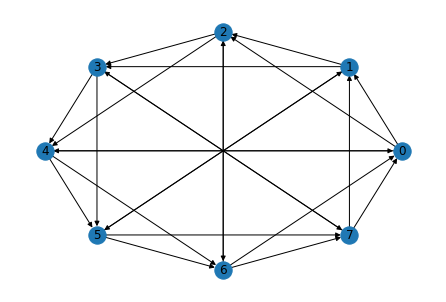

In [4]:
G = topology_util.ExponentialTwoGraph(8)
labels={i: i for i in range(8)}
nx.draw_circular(G, labels=labels)

## 2.2 Decentralized ADMM

Continue on the centralized ADMM algorithm. We consider the same consensus problem:
$$
    \min_{x} \sum_{i=1}^n f_i(x)
$$
Instead of relaxing $x$ into $\{x_i\}$ and forcing them to be the common value $y$, we can map it into a graph structure. More percisely, assigning $f_i$ into each vertex and relaxing the common $x$ by $\{x_i\}$ owned by each vertex. The constraint of $x_i = x_j$ can be transfered into constrain on the edge:

\begin{align}
    \min_{\{x_i\}_{i\in V},\; \{y_e\}_{e\in E} }&\;\; \sum_{i=1}^n f_i(x_i)\\
    {\rm subject\ to} &\;\; x_i - y_e=0,\;  x_j - y_e=0, \;\;\forall e=\{i,j\} \in E
\end{align}

As long as the graph is connected, it is easy to see it is equivalent to original consenus problem.

To solve this, we consider the augmented Lagrangian and the dual variables $u_{e,i}$ for $x_i - y_e=0$ and $u_{e,j}$ for $x_j - y_e=0$. After applying the ADMM algorithm and simplifying, we obtain

\begin{align}
    x_{i}^{k+1} =& {\rm Prox}_{(\alpha |N_i|)^{-1} f_i} (v_i^k)\\
    a_{i}^{k+1} =& \frac{1}{2} x_i + \frac{1}{2|N_i|} \sum_{j\in N_i} x_j^{k+1}\\
    v_{i}^{k+1} =& v_{i}^{k} + a_{i}^{k+1} - a_{i}^{k}
\end{align}

The code snippet:
```python
def DecentralizedADMMStepL2(A, b, x, a, v, n_i, alpha):
    next_x = ProximalStepL2(A, b, v, n_i, alpha)
    neighbor_weights = {r: 0.5 / n_i for r in bf.in_neighbor_ranks()}
    next_a = bf.neighbor_allreduce(
        next_x, self_weight=0.5, neighbor_weights=neighbor_weights
    )   # <-- this is the key difference. Chaning from allreduce to neighbor_allreduce
    next_v = v + next_a - a
    return next_x, next_a, next_v
```

In [5]:
! bfrun -np 4 python DecentralizedADMM.py

[Decentralized ADMM] Rank 0: ADMM residue gradient norm: 1.251637293088542e-14
[Decentralized ADMM] Rank 1: ADMM residue gradient norm: 1.251637293088542e-14
[Decentralized ADMM] Rank 2: ADMM residue gradient norm: 1.251637293088542e-14
[Decentralized ADMM] Rank 3: ADMM residue gradient norm: 1.251637293088542e-14
Last three entries of x_ar:
 tensor([[0.6872],
        [0.6552],
        [0.8751]], dtype=torch.float64)
Last three entries of x_admm:
 tensor([[0.6686],
        [0.6946],
        [0.8056]], dtype=torch.float64)


## 2.3 Mixing matrix

For commonly used undirected network, BlueFog provides the mixing matrix generated through the Metropolis–Hastings rule. 

> **Metropolis-Hastings rule.** Providing a undirected and connected topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + \max\{d_i, d_j \}},& \mbox{if $j \in \mathcal{N}(i)$}, \\
			\hspace{-2mm}\displaystyle 1 - \sum_{j\in \mathcal{N}(i)}w_{ij}, & \mbox{if $i = j$},\\
			\hspace{-2mm}0,& \mbox{if $j \notin \mathcal{N}(i)$  and $j\neq i$}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d_i = |\mathcal{N}(i)|$ (the number of incoming neighbors of agent $k$). It is easy to verify such $W$ is always doubly-stochastic.

### 2.3.1 Mixing matrix for the ring

The following code is to fetch mixing matrix provided by BlueFog.

```python
def FetchRingMixingMatrix(network_size):
    G = topology_util.RingGraph(network_size)   # organize nodes into a ring
    W = np.zeros((network_size, network_size))  # genearate an empty mixing matrix 

    for rank in range(network_size):
        self_weight, neighbor_weights = topology_util.GetRecvWeights(G, rank)  # fetch weights
        W[rank,rank] = self_weight              # put weights into the mixing matrix
        for r, v in neighbor_weights.items():
            W[rank, r] = v
            
    return W
```

In [6]:
! bfrun -np 8 python Ring_mixingMatrix.py

[[0.333 0.333 0.    0.    0.    0.    0.    0.333]
 [0.333 0.333 0.333 0.    0.    0.    0.    0.   ]
 [0.    0.333 0.333 0.333 0.    0.    0.    0.   ]
 [0.    0.    0.333 0.333 0.333 0.    0.    0.   ]
 [0.    0.    0.    0.333 0.333 0.333 0.    0.   ]
 [0.    0.    0.    0.    0.333 0.333 0.333 0.   ]
 [0.    0.    0.    0.    0.    0.333 0.333 0.333]
 [0.333 0.    0.    0.    0.    0.    0.333 0.333]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.804737854124365


### 2.3.2 Mixing matrix for the Star

In [7]:
! bfrun -np 8 python Mesh_mixingMatrix.py

[[0.417 0.25  0.    0.    0.333 0.    0.    0.   ]
 [0.25  0.25  0.25  0.    0.    0.25  0.    0.   ]
 [0.    0.25  0.25  0.25  0.    0.    0.25  0.   ]
 [0.    0.    0.25  0.417 0.    0.    0.    0.333]
 [0.333 0.    0.    0.    0.417 0.25  0.    0.   ]
 [0.    0.25  0.    0.    0.25  0.25  0.25  0.   ]
 [0.    0.    0.25  0.    0.    0.25  0.25  0.25 ]
 [0.    0.    0.    0.333 0.    0.    0.25  0.417]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.8535533905932756


### 2.3.3 Mixing matrix for Exponential-two Graph

In the exponential-two graph, each node has the same incoming degree and outgoing degree. Exponential-two graph is a directed graph, BlueFog provides a mixing matrix following averaging rule for Exponential-two graph.

> **Averaging rule.** Providing an exponential-two topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + d},& \mbox{if $j \in \mathcal{N}_{\rm in}(i)$ or if $i = j$} , \\
			0,& \mbox{otherwise}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d = |\mathcal{N}_{\rm in}(i)|$ (the number of incoming neighbors of agent $i$). It is easy to verify such $W$ is always doubly-stochastic because incoming degree $d$ of each node is the same.

Since Exponential-two Graph is a regular graph, such mixing matrix is doubly stochastic but not symmetric.

In [8]:
! bfrun -np 8 python Exp2_mixingMatrix.py

[[0.25 0.   0.   0.   0.25 0.   0.25 0.25]
 [0.25 0.25 0.   0.   0.   0.25 0.   0.25]
 [0.25 0.25 0.25 0.   0.   0.   0.25 0.  ]
 [0.   0.25 0.25 0.25 0.   0.   0.   0.25]
 [0.25 0.   0.25 0.25 0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.25 0.25 0.25 0.   0.  ]
 [0.   0.   0.25 0.   0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.25 0.25]]

The sum of each col is: [1. 1. 1. 1. 1. 1. 1. 1.]
The sum of each row is: [1. 1. 1. 1. 1. 1. 1. 1.]
W is doubly stochastic.
The second largest eigenvalue is: 0.5000000000000003


### 2.3.4 Commonly-used topology summary

The following table summarizes the second largest eigenvalue and the maximum degree of some common network topologes. The mixing matrix of the undirected topologies, i.e., the ring, 2D-mesh, and fully-connected topology, are generated through the Matropolis-Hastings  rule, while the mixing matrix of exponential-2 topology (which is a directed network) is genereted through the Averaging rule. 


| Network topology | second largest eigenvalue | maximum degree |
| -: | :-: | :-: |
| Undirected Ring | $1-O(\frac{1}{n^2})$ | 2 |
| Undirected 2D-Mesh | $1-O(\frac{1}{n})$ | 4 |
| Exponential-2 | $1-O(\frac{1}{\ln(n)})$ | $\ln(n)$ |
| Fully connected| $0$ |$n-1$ |  

## 2.4 Average consensus

Given the mixing matrix, the average consensus algorithm is:

$$x_i^{k+1} = \sum_{j \in \mathcal{N}_i \cup \{i\}} w_{ij} x_j^{k}$$

It is guaranteed that $ \frac{1}{n}\sum_{i=1}^n \|x_i^k - \frac{1}{n}\sum_{i=1}^n x_i^0\|^2 \le C \rho^{2k}$, where $\rho$ is the second largest eigenvalue of the matrix $W$. Apparently, $\rho$ decides the convergence rate of the average consensus algorithm. One step of average consensus can be conducted as

```python
G = topology_util.RingGraph(bf.size())  # set up the topology
bf.set_topology(G, is_weighted=True)    # organize nodes into the topology
# one-step average consensus
def avg_consensus_one_step(x):
    x_next = bf.neighbor_allreduce(x)
    return x_next
```

In [9]:
! bfrun -np 8 python AverageConsensus.py

Runing average consensus with topology Ring
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60
Runing average consensus with topology Mesh
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60
Runing average consensus with topology Exp2
Progress 0/60
Progress 10/60
Progress 20/60
Progress 30/60
Progress 40/60
Progress 50/60


Text(0, 0.5, 'Relative error')

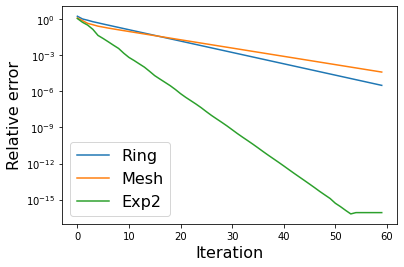

In [10]:
import scipy.io as sio
rel_error_dict = sio.loadmat('aveCns.mat')

for graph in ['Ring', 'Mesh', 'Exp2']:
    record = rel_error_dict[graph].reshape(-1)
    plt.semilogy(record)
    
plt.legend(['Ring', 'Mesh', 'Exp2'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)

Recall that $\rho_{\rm ring} = 0.80, \rho_{\rm mesh} = 0.85, \rho_{\rm exp2} = 0.50$. The above figure depicts the influence of $\rho$. 

## 2.5 Decentralized gradient descent

Recall the optimization problem:

\begin{align*}
\min_{x\in \mathbb{R}^d}\ \sum_{i=1}^n h_i(x)\hspace{1cm}  \mbox{(Opt-Problem)}
\end{align*}

Decentralized gradient descent has two fomulations: 

\begin{align}
x_i^{(k+1)} &= \sum_{j\in \mathcal{N}_i \cup \{i\}} w_{ij} \Big(x_j^{(k)} - \alpha \nabla h_j(x_j^{(k)}) \Big)  \hspace{2.1cm} \mbox{(adaptation-then-combination, ATC-DGD)}\\ 
x_i^{(k+1)} &= \sum_{j\in \mathcal{N}_i \cup \{i\}} w_{ij} x_j^{(k)} - \alpha \nabla h_i(x_i^{(k)})   \hspace{2.6cm} \mbox{(adaptation-with-combination, AWC-DGD)}
\end{align}

The comparison between ATC and AWC DGD is as follows:

- ATC-DGD has smaller limiting bias than AWC-DGD


- ATC-DGD has a wider step-size stability range than AWC-DGD


- AWC-DGD can easily overlap communication and computation, and hence is more efficient per iteration than ATC-DGD


### 2.5.1 Compare limiting bias

In the following example, we will consider the simple scenario in which $h_i(x) = \frac{1}{2}\|A_i x - b_i\|^2$. The main code is as follows:

```Python
G = topology_util.RingGraph(bf.size())  # set up the topology
bf.set_topology(G, is_weighted=True)    # organize nodes into the topology

# one-step AWC-DGD. 
def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):

    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_next = bf.neighbor_allreduce(x) - alpha*grad_local     # AWC update

    return x_next

# one-step ATC-DGD. 
def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):

    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination

    return x_next
```

In [11]:
! bfrun -np 8 python DGD_limitBias.py

[Distributed Grad Descent] Rank 0: global gradient norm: 3.7252473072675936e-13

Running ATC:
Progress 0/200
Progress 100/200

Running AWC:
Progress 0/200
Progress 100/200


Text(0.5, 1.0, 'step-size: 5e-3')

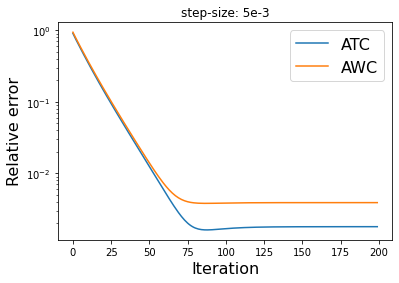

In [12]:
import scipy.io as sio
rel_error_dict = sio.loadmat('DGD_limitBias.mat')

for method in ['ATC', 'AWC']:
    record = rel_error_dict[method].reshape(-1)
    plt.semilogy(record)
    
plt.legend(['ATC', 'AWC'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
plt.title('step-size: 5e-3')

It is observed in the above figure that with the same step-size, ATC can converge to a better solution than AWC.

### 2.5.2 Compare stability range

In [13]:
! bfrun -np 8 python DGD_stability.py

[Distributed Grad Descent] Rank 0: global gradient norm: 3.7252473072675936e-13

Running ATC:
Progress 0/200
Progress 100/200

Running AWC:
Progress 0/200
Progress 100/200


Text(0.5, 1.0, 'step-size: 5e-2')

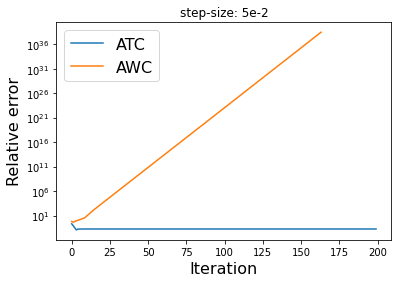

In [14]:
import scipy.io as sio
rel_error_dict = sio.loadmat('DGD_stability.mat')

for method in ['ATC', 'AWC']:
    record = rel_error_dict[method].reshape(-1)
    plt.semilogy(record)
    
plt.legend(['ATC', 'AWC'], fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)
plt.title('step-size: 5e-2')

When we enlarge the step-size, it is observed that AWC diverges while ATC can still converge

### 2.5.3 Compare communication and computation overlapping

\[Bicheng: Can you add some contexts on the overlapping? You have an illustrative figure, right?\]

In [15]:
%%writefile NonBlocking.py

import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import scipy.io as sio
import time

bf.init()

def generate_data(m, d, x_o):
    A = torch.randn(m, d).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
    
    return A, b

def check_opt_cond(x, A, b):
    
    grad_local = A.t().mm(A.mm(x) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient
    
    # the norm of global gradient is expected to be 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))
        
    return

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    m, d = A.shape
    
    x_opt = torch.zeros(d, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad
    
    return x_opt

def ATC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step ATC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)      # compute local grad
#     time.sleep(0.05)
    y = x - alpha*grad_local                # adapte
    x_new = bf.neighbor_allreduce(y)        # combination
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

def AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step AWC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
    x_new = bf.neighbor_allreduce(x) - alpha*grad_local      # AWC update
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

def NonBlocking_AWC_DGD_one_step(x, x_opt, A, b, alpha=1e-2):
    
    # one-step NBK-AWC-DGD. 
    # The combination weights have been determined by the associated combination matrix.
    
    x_handle = bf.neighbor_allreduce_nonblocking(x)
    grad_local = A.t().mm(A.mm(x) - b)                       # compute local grad
#     time.sleep(0.05)
    x_new = bf.synchronize(x_handle) - alpha*grad_local      # AWC update
    
    # the relative error: |x^k-x_gloval_average|/|x_gloval_average|
    rel_error = torch.norm(x_new-x_opt, p=2)/torch.norm(x_opt,p=2)

    return x_new, rel_error

if __name__ == "__main__":
    
    torch.manual_seed(12345 * bf.rank())
    
    m, d = 20, 2000 # dimension of A
    x_o = torch.rand(d,1).to(torch.double)
    x_o = bf.broadcast(x_o, root_rank = 0)
    A, b = generate_data(m, d, x_o)
    x_opt = distributed_grad_descent(A, b, maxite=200, alpha=1e-2)
    
    G = topology_util.ExponentialTwoGraph(bf.size()) # Set topology as exponential-two topology.
    bf.set_topology(G)

    maxite = 3000
    alpha = 5e-3
    rel_error_dict = {}
    
    for method in ['ATC', 'AWC', 'NBK-AWC']:
        
        start = time.time()
        
        if bf.rank() == 0:
            print('\nRunning {}:'.format(method))
    
        x = torch.zeros(d, 1, dtype=torch.double).to(torch.double)        # Initialize x
        rel_error = torch.zeros((maxite, 1))
        for ite in range(maxite):

            if bf.rank()==0:
                if ite%500 == 0:
                    print('Progress {}/{}'.format(ite, maxite))

            if method == 'ATC':
                x, rel_error[ite] = ATC_DGD_one_step(x, x_opt, A, b, alpha=alpha) # you can adjust alpha to different values
            elif method == 'NBK-AWC':
                x, rel_error[ite] = NonBlocking_AWC_DGD_one_step(x, x_opt, A, b, alpha=alpha) # you can adjust alpha to different values
            else:
                AWC_DGD_one_step(x, x_opt, A, b, alpha=alpha)
                
        rel_error_dict[method] = rel_error.cpu().detach().numpy().reshape(-1)
        
        end = time.time()
        
        if bf.rank() == 0:
            print('{} finishes in {} seconds.'.format(method, end - start))
        
if bf.rank() == 0:
    sio.savemat('NonBlocking.mat', rel_error_dict)

Overwriting NonBlocking.py


In [16]:
! bfrun -np 8 python NonBlocking.py


Running ATC:
Progress 0/3000
Progress 500/3000
Progress 1000/3000
Progress 1500/3000
Progress 2000/3000
Progress 2500/3000
ATC finishes in 5.028935194015503 seconds.

Running AWC:
Progress 0/3000
Progress 500/3000
Progress 1000/3000
Progress 1500/3000
Progress 2000/3000
Progress 2500/3000
AWC finishes in 5.110978126525879 seconds.

Running NBK-AWC:
Progress 0/3000
Progress 500/3000
Progress 1000/3000
Progress 1500/3000
Progress 2000/3000
Progress 2500/3000
NBK-AWC finishes in 4.698365211486816 seconds.


It is observed that Nonblocking-AWC has the shortest time to finish $3000$ iterations through overlapping of communication and computation.